In [1]:
import pandas as pd
import pprint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor as rfr
from xgboost import XGBClassifier as xgb


In [2]:
cta = pd.read_csv('CTA_-_Ridership_-__L__Station_Entries_-_Daily_Totals.csv')
cta.head()

,station_id,stationname,date,daytype,rides
0,40010,Austin-Forest Park,01/01/2001,U,290
1,40020,Harlem-Lake,01/01/2001,U,633
2,40030,Pulaski-Lake,01/01/2001,U,483
3,40040,Quincy/Wells,01/01/2001,U,374
4,40050,Davis,01/01/2001,U,804


In [3]:
import datetime

def mydate(mystr):
    m,d,y = [int(i) for i in mystr.split('/')]
    return datetime.datetime(y,m,d)

# decimalized month for monthly plotting
def decmo(mydate):
    lens = [31,28 + (mydate.year % 4 == 0),31,30,31,30,31,31,30,31,30,31]
    # all divisible by four are leap years, last exception was 1900
    return mydate.month + mydate.day/lens[mydate.month - 1]


In [4]:
cta['date'] = cta['date'].apply(mydate,1)
cta['day'] = cta['date'].apply(lambda x: x.day)
cta['month'] = cta['date'].apply(lambda x: x.month)
cta['year'] = cta['date'].apply(lambda x: x.year)
cta['weekday'] = cta['date'].apply(lambda x: ['Mon','Tue','Wed','Thu','Fri','Sat','Sun'][x.weekday()])
cta['decmo'] = cta['date'].apply(decmo,1)
cta.head()

,station_id,stationname,date,daytype,rides,day,month,year,weekday,decmo
0,40010,Austin-Forest Park,2001-01-01,U,290,1,1,2001,Mon,1.032258
1,40020,Harlem-Lake,2001-01-01,U,633,1,1,2001,Mon,1.032258
2,40030,Pulaski-Lake,2001-01-01,U,483,1,1,2001,Mon,1.032258
3,40040,Quincy/Wells,2001-01-01,U,374,1,1,2001,Mon,1.032258
4,40050,Davis,2001-01-01,U,804,1,1,2001,Mon,1.032258


Everything is self explanatory but daytype

In [5]:
cta.daytype.value_counts()

W    565419
U    128848
A    115059
Name: daytype, dtype: int64

I want to find out what U, A, W mean. I suspect they have to do with the day of the week.

In [6]:
ctaw = cta[cta.daytype == 'W']
ctaw.weekday.value_counts()

Tue    114625
Wed    114625
Fri    114328
Thu    112335
Mon    109506
Name: weekday, dtype: int64

In [7]:
ctaa = cta[cta.daytype == 'A']
ctaa.weekday.value_counts()

Sat    115059
Name: weekday, dtype: int64

In [8]:
ctau = cta[cta.daytype == 'U']
ctau.weekday.value_counts()

Sun    115617
Mon      6117
Thu      3272
Fri      1282
Wed       998
Tue       996
Sat       566
Name: weekday, dtype: int64

Judging from these distributions, it looks like W are normal weekdays, A are normal saturdays, U are Sundays and holidays/sports games. To make sure, I'll look at the non-Sunday U values.

In [9]:
ctauns = ctau[ctau.weekday != 'Sun']
ctauns = ctauns.drop_duplicates(subset = ['date','stationname'])
#this will get station-specific drops
ctauns.head()

,station_id,stationname,date,daytype,rides,day,month,year,weekday,decmo
0,40010,Austin-Forest Park,2001-01-01,U,290,1,1,2001,Mon,1.032258
1,40020,Harlem-Lake,2001-01-01,U,633,1,1,2001,Mon,1.032258
2,40030,Pulaski-Lake,2001-01-01,U,483,1,1,2001,Mon,1.032258
3,40040,Quincy/Wells,2001-01-01,U,374,1,1,2001,Mon,1.032258
4,40050,Davis,2001-01-01,U,804,1,1,2001,Mon,1.032258


(1, 13)

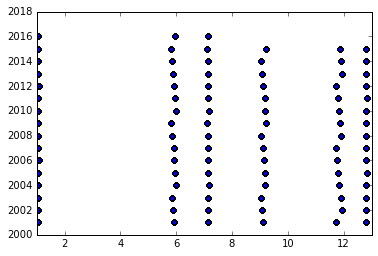

In [10]:
plt.scatter(ctauns.decmo,ctauns.year)
plt.xlim(1,13)

The non-Sunday U days are around New Years, Memorial Day, July 4, Labor Day, Thanksgiving, and Christmas.

Note also that U is not station-specific -- all these U values are constant for all stations.

In [11]:
cta.stationname.unique()

array(['Austin-Forest Park', 'Harlem-Lake', 'Pulaski-Lake', 'Quincy/Wells',
       'Davis', "Belmont-O'Hare", 'Jackson/Dearborn', 'Sheridan',
       'Damen-Brown', 'Morse', '35th/Archer', '51st', 'Skokie',
       'Pulaski-Cermak', 'LaSalle/Van Buren', 'Ashland-Lake',
       'Oak Park-Forest Park', 'Sox-35th-Dan Ryan', 'Randolph/Wabash',
       'Damen-Cermak', 'Western-Forest Park', 'Cumberland', '79th',
       'Kedzie-Homan-Forest Park', 'State/Lake', 'Main', 'Central-Lake',
       'Ashland/63rd', 'Indiana', 'Western-Orange', 'Division/Milwaukee',
       'Grand/State', 'Berwyn', 'UIC-Halsted', 'Southport',
       'Washington/Dearborn', 'Clark/Lake', 'Forest Park', 'Noyes',
       'Cicero-Cermak', 'Clinton-Forest Park', 'California-Cermak',
       '95th/Dan Ryan', 'Merchandise Mart', 'Racine', 'Cicero-Lake',
       'Grand/Milwaukee', 'Washington/State', 'Garfield-South Elevated',
       'Foster', 'Diversey', 'Wilson', "Irving Park-O'Hare",
       'Jackson/State', 'California/Milwaukee',

In [12]:
cta.station_id.unique()

array([40010, 40020, 40030, 40040, 40050, 40060, 40070, 40080, 40090,
       40100, 40120, 40130, 40140, 40150, 40160, 40170, 40180, 40190,
       40200, 40210, 40220, 40230, 40240, 40250, 40260, 40270, 40280,
       40290, 40300, 40310, 40320, 40330, 40340, 40350, 40360, 40370,
       40380, 40390, 40400, 40420, 40430, 40440, 40450, 40460, 40470,
       40480, 40490, 40500, 40510, 40520, 40530, 40540, 40550, 40560,
       40570, 40580, 40590, 40600, 40610, 40630, 40640, 40650, 40660,
       40670, 40680, 40690, 40700, 40710, 40720, 40730, 40740, 40750,
       40760, 40770, 40780, 40790, 40800, 40810, 40820, 40830, 40840,
       40850, 40870, 40880, 40890, 40900, 40910, 40920, 40930, 40940,
       40960, 40970, 40980, 40990, 41000, 41010, 41020, 41030, 41040,
       41050, 41060, 41070, 41080, 41090, 41120, 41130, 41140, 41150,
       41160, 41170, 41180, 41190, 41200, 41210, 41220, 41230, 41240,
       41250, 41260, 41270, 41280, 41290, 41300, 41310, 41320, 41330,
       41340, 41350,

I just want to work with stations active the whole time, so I look at those active on the first and last day

In [13]:
old = cta[cta.date == datetime.datetime(2001,1,1)]
old_stations = set(old.stationname.tolist())
new = cta[cta.date == datetime.datetime(2016,7,31)]
new_stations = set(new.stationname.tolist())
good_stations = list(old_stations.intersection(new_stations))

Next I get yearly totals, both overall and by station, and then calculate the percentage of yearly ridership that each station represents.

In [14]:
cta = cta[cta.daytype == 'U']

In [15]:
ytotals = pd.DataFrame(cta.groupby(['year','month'], as_index = False)['rides'].mean())
ytotals['stationname'] = ['Total']*len(ytotals)
ytotals.head()

,year,month,rides,stationname
0,2001,1,968.602837,Total
1,2001,2,1045.698582,Total
2,2001,3,1083.195035,Total
3,2001,4,1116.078014,Total
4,2001,5,1214.441135,Total


In [16]:
sytotals = pd.DataFrame(cta.groupby(['stationname','year','month'], as_index = False)['rides'].sum())
sytotals = pd.concat([ytotals, sytotals], ignore_index = True)
sytotals.head(30)

,month,rides,stationname,year
0,1,968.602837,Total,2001
1,2,1045.698582,Total,2001
2,3,1083.195035,Total,2001
3,4,1116.078014,Total,2001
4,5,1214.441135,Total,2001
5,6,1420.558099,Total,2001
6,7,1471.863636,Total,2001
7,8,1382.174296,Total,2001
8,9,1249.589202,Total,2001
9,10,1351.281690,Total,2001


Now I build a model here to predict ridership by station/year/month.

In [17]:
months = list(range(1,13))
downlist = []
years = list(range(2001,2017))
cols = ['rides']
names = ['station']
datalist = []
for station in good_stations:
    a = sytotals.stationname == station
    slist = [station]
    for year in years:
        b = sytotals.year == year
        for month in months:
            c = sytotals.month == month
            st = sytotals[a][b][c]
            if len(st) > 0:
                for col in cols:
                    ycname = str(year) + '_' + str(month) + '_' + col
                    if ycname not in names:
                        names.append(ycname)
                    slist.append(sytotals[a][b][c][col].values[0])
            else:
                if year < 2016:# not appending 2016 stuff cause half year, known
                    downlist.append([station,year,month])
        datalist.append(slist)
        

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [18]:
downlist

[['95th/Dan Ryan', 2013, 9],
 ['Sox-35th-Dan Ryan', 2013, 9],
 ['Cermak-Chinatown', 2013, 9],
 ['47th-Dan Ryan', 2013, 9],
 ['79th', 2013, 9],
 ['87th', 2013, 9],
 ['63rd-Dan Ryan', 2013, 9],
 ['69th', 2013, 9],
 ['Garfield-Dan Ryan', 2013, 9]]

Apparently a major local shutdown in September 2013.

In [19]:
data = pd.DataFrame(data = datalist, columns = names)
data.head()

,station,2001_1_rides,2001_2_rides,2001_3_rides,2001_4_rides,2001_5_rides,2001_6_rides,2001_7_rides,2001_8_rides,2001_9_rides,...,2015_10_rides,2015_11_rides,2015_12_rides,2016_1_rides,2016_2_rides,2016_3_rides,2016_4_rides,2016_5_rides,2016_6_rides,2016_7_rides
0,Pulaski-Forest Park,2874.0,2445.0,2545.0,3226.0,3359.0,2868.0,4781.0,3020.0,4179.0,...,5183.0,8101.0,6362.0,6812.0,4999.0,4913.0,5057.0,7133.0,5170.0,7826.0
1,Pulaski-Forest Park,2874.0,2445.0,2545.0,3226.0,3359.0,2868.0,4781.0,3020.0,4179.0,...,5183.0,8101.0,6362.0,6812.0,4999.0,4913.0,5057.0,7133.0,5170.0,7826.0
2,Pulaski-Forest Park,2874.0,2445.0,2545.0,3226.0,3359.0,2868.0,4781.0,3020.0,4179.0,...,5183.0,8101.0,6362.0,6812.0,4999.0,4913.0,5057.0,7133.0,5170.0,7826.0
3,Pulaski-Forest Park,2874.0,2445.0,2545.0,3226.0,3359.0,2868.0,4781.0,3020.0,4179.0,...,5183.0,8101.0,6362.0,6812.0,4999.0,4913.0,5057.0,7133.0,5170.0,7826.0
4,Pulaski-Forest Park,2874.0,2445.0,2545.0,3226.0,3359.0,2868.0,4781.0,3020.0,4179.0,...,5183.0,8101.0,6362.0,6812.0,4999.0,4913.0,5057.0,7133.0,5170.0,7826.0


In [20]:
data = data.drop_duplicates()

In [21]:
data.dropna(inplace = True)
data = data.reset_index(drop=True)
data.head()

,station,2001_1_rides,2001_2_rides,2001_3_rides,2001_4_rides,2001_5_rides,2001_6_rides,2001_7_rides,2001_8_rides,2001_9_rides,...,2015_10_rides,2015_11_rides,2015_12_rides,2016_1_rides,2016_2_rides,2016_3_rides,2016_4_rides,2016_5_rides,2016_6_rides,2016_7_rides
0,Pulaski-Forest Park,2874.0,2445.0,2545.0,3226.0,3359.0,2868.0,4781.0,3020.0,4179.0,...,5183.0,8101.0,6362.0,6812.0,4999.0,4913.0,5057.0,7133.0,5170.0,7826.0
1,Clinton-Forest Park,3016.0,2594.0,2664.0,3316.0,3581.0,3035.0,4776.0,3516.0,4919.0,...,7443.0,9068.0,6352.0,6986.0,5108.0,5768.0,5577.0,8777.0,5736.0,8816.0
2,35-Bronzeville-IIT,2880.0,2758.0,2764.0,3358.0,3136.0,2814.0,4333.0,2821.0,4573.0,...,5999.0,5597.0,3596.0,4088.0,3252.0,2959.0,3516.0,4579.0,3388.0,5738.0
3,Jackson/State,9388.0,8503.0,9592.0,11790.0,12487.0,13717.0,31443.0,10656.0,14961.0,...,22418.0,19317.0,12239.0,14696.0,12857.0,10735.0,14252.0,21966.0,20362.0,27852.0
4,Oak Park-Lake,1429.0,1327.0,1470.0,2009.0,2230.0,2220.0,3220.0,2107.0,2587.0,...,3007.0,3351.0,2514.0,2417.0,1970.0,1879.0,497.0,1404.0,2792.0,4204.0


In [22]:
cutoff = -24
X, y = data[names[1:cutoff]], data[names[cutoff:]]

In [23]:
models = [LinearRegression(), Lasso(), Ridge(), ElasticNet(),rfr()]
modelnames = ['LinReg','Lasso','Ridge','ElasticNet','RF']

for i in range(len(models)):
    print('\n' + modelnames[i] + ':\n')
    cvs = cross_val_score(models[i], X, y, n_jobs = 1, cv = 5)
    print('Cross Val Scores: ' + str(cvs)[1:-1])
    print('Mean Score: ' + str(np.mean(cvs)))



LinReg:

Cross Val Scores:  0.6497457   0.74724413  0.83931275  0.71253208  0.69723787
Mean Score: 0.729214505911

Lasso:



//anaconda/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/

Cross Val Scores:  0.73123368  0.90503422  0.85238338  0.87895429  0.90962547
Mean Score: 0.855446205653

Ridge:

Cross Val Scores:  0.64975014  0.74724571  0.83931359  0.71253348  0.69723998
Mean Score: 0.729216579338

ElasticNet:



//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)
//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase th

Cross Val Scores:  0.73123147  0.90503379  0.85238027  0.87895355  0.90962488
Mean Score: 0.855444793249

RF:

Cross Val Scores:  0.91124143  0.90135104  0.91242168  0.88740223  0.87945908
Mean Score: 0.898375091819


Since the Random Forest and Lasso/ElasticNet had similar high scores despite their different approaches, we can make a robust model with a simple arithmetic mean.

We can use these to predict the next few years.

In [24]:
modelrf, modellas = rfr(), Lasso()
modelrf.fit(X,y), modellas.fit(X,y)

//anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:466: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
 Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
    normalize=False, positive=False, precompute=False, random_state=None,
    selection='cyclic', tol=0.0001, warm_start=False))

In [25]:
X_future = data[names[1-cutoff:]]
X_future.head()

,2003_1_rides,2003_2_rides,2003_3_rides,2003_4_rides,2003_5_rides,2003_6_rides,2003_7_rides,2003_8_rides,2003_9_rides,2003_10_rides,...,2015_10_rides,2015_11_rides,2015_12_rides,2016_1_rides,2016_2_rides,2016_3_rides,2016_4_rides,2016_5_rides,2016_6_rides,2016_7_rides
0,3065.0,2566.0,3220.0,2480.0,3177.0,3534.0,3648.0,3646.0,3648.0,3134.0,...,5183.0,8101.0,6362.0,6812.0,4999.0,4913.0,5057.0,7133.0,5170.0,7826.0
1,3215.0,2698.0,3574.0,2885.0,3621.0,3835.0,4022.0,3949.0,4462.0,3768.0,...,7443.0,9068.0,6352.0,6986.0,5108.0,5768.0,5577.0,8777.0,5736.0,8816.0
2,3074.0,2755.0,3516.0,3015.0,3118.0,3981.0,4100.0,4147.0,4335.0,3811.0,...,5999.0,5597.0,3596.0,4088.0,3252.0,2959.0,3516.0,4579.0,3388.0,5738.0
3,10056.0,8402.0,11621.0,8351.0,12464.0,18390.0,21710.0,10215.0,8299.0,19533.0,...,22418.0,19317.0,12239.0,14696.0,12857.0,10735.0,14252.0,21966.0,20362.0,27852.0
4,1507.0,1369.0,2104.0,1598.0,2147.0,2947.0,2815.0,2632.0,2181.0,2114.0,...,3007.0,3351.0,2514.0,2417.0,1970.0,1879.0,497.0,1404.0,2792.0,4204.0


In [26]:
future_pred = (modelrf.predict(X_future) + modellas.predict(X_future))/2

These are ahead of our test set by (-cutoff/12) years.

In [27]:
fpcols = []
for col in y.columns:
    fpcols.append(col[:3] + str(int(int(col[3]) - cutoff/12)) + col[4:])

In [28]:
fp = pd.DataFrame(data = future_pred, columns = fpcols)
fp['station'] = data['station']
fp.head()

,2016_8_rides,2016_9_rides,2016_10_rides,2016_11_rides,2016_12_rides,2017_1_rides,2017_2_rides,2017_3_rides,2017_4_rides,2017_5_rides,...,2017_11_rides,2017_12_rides,2018_1_rides,2018_2_rides,2018_3_rides,2018_4_rides,2018_5_rides,2018_6_rides,2018_7_rides,station
0,9165.685271,9257.434491,7060.451576,7538.552749,6441.553502,5903.152232,4459.031367,5770.168252,3897.677194,5985.782959,...,7275.742066,5462.226163,5530.491667,4361.189237,4320.436976,3680.376314,6105.007877,6104.643035,7562.504606,Pulaski-Forest Park
1,9877.440118,10536.908188,8141.938224,9301.754055,7563.299943,6695.926301,4935.259555,7160.339743,5458.116002,8489.492378,...,9100.006525,6617.516932,6743.273673,5184.036546,5522.252512,5433.157077,8411.004904,6684.836526,9096.793049,Clinton-Forest Park
2,6400.218399,6301.423197,5929.611990,5595.794349,3751.820068,4257.445738,3458.560744,4870.033285,3483.611588,5307.421145,...,6108.768743,3843.439176,4040.481006,3334.435303,3624.226906,3759.632121,5244.755430,3740.031892,7198.117588,35-Bronzeville-IIT
3,20246.228843,18697.344241,18887.415683,16179.666623,12147.852397,8289.399639,5854.097751,9451.137312,4010.683406,5768.817383,...,13296.593769,8313.280912,5927.171906,5336.865708,7071.399458,11192.401333,16247.024533,10744.149716,13281.897703,Jackson/State
4,4583.236451,4294.586674,3409.640662,3986.545892,3232.024050,2606.807740,1907.565394,2955.664587,2119.293126,3506.563170,...,3805.581780,2831.473432,2512.246576,2064.031822,2201.071286,2027.197801,3733.011816,3468.809859,4925.976889,Oak Park-Lake


In [29]:
numcols = list(fp.columns[:-1])
yearvals, monthvals = [],[]
for col in numcols:
    [y,m,junk] = col.split('_')
    yearvals.append(int(y))
    monthvals.append(int(m))

In [30]:
stations = fp.station.values.tolist()
for station in stations:
    colvals = fp[fp.station == station]

In [31]:
databack = pd.DataFrame(data = [], columns = ['stationname','year','month','rides'])
for i in range(len(fp)):#
    riders = fp.iloc[i].tolist()[:-1]
    stats = [fp.iloc[i].tolist()[-1]]*len(riders)
    datasub = pd.DataFrame(data = stats, columns = ['stationname'])
    datasub['year'], datasub['month'] = yearvals, monthvals
    datasub['rides'] = riders
    databack = pd.concat([databack,datasub])

In [32]:
databack = databack.reset_index(drop=True)
databack.head(50)

,stationname,year,month,rides
0,Pulaski-Forest Park,2016.0,8.0,9165.685271
1,Pulaski-Forest Park,2016.0,9.0,9257.434491
2,Pulaski-Forest Park,2016.0,10.0,7060.451576
3,Pulaski-Forest Park,2016.0,11.0,7538.552749
4,Pulaski-Forest Park,2016.0,12.0,6441.553502
5,Pulaski-Forest Park,2017.0,1.0,5903.152232
6,Pulaski-Forest Park,2017.0,2.0,4459.031367
7,Pulaski-Forest Park,2017.0,3.0,5770.168252
8,Pulaski-Forest Park,2017.0,4.0,3897.677194
9,Pulaski-Forest Park,2017.0,5.0,5985.782959


In [33]:
def topten(dataframe, n, extratext = ''):
    dfsort = pd.DataFrame(dataframe.groupby(['stationname'], as_index = False)['rides'].mean())
    dfsort = dfsort.sort_values('rides', ascending = False)[:n]


    fig, ax = plt.subplots(figsize = [10,10])#


    error_config = {'ecolor': '0.3'}

    rects1 = plt.bar(np.arange(n), dfsort.rides)

    plt.xlabel('Stop')
    plt.ylabel('Mean Daily Riders')
    plt.title('Mean Daily Riders By Stop ' + extratext)
    plt.xticks(np.arange(n)+.5,dfsort.stationname, rotation = 90)


In [34]:
databack.head()

,stationname,year,month,rides
0,Pulaski-Forest Park,2016.0,8.0,9165.685271
1,Pulaski-Forest Park,2016.0,9.0,9257.434491
2,Pulaski-Forest Park,2016.0,10.0,7060.451576
3,Pulaski-Forest Park,2016.0,11.0,7538.552749
4,Pulaski-Forest Park,2016.0,12.0,6441.553502


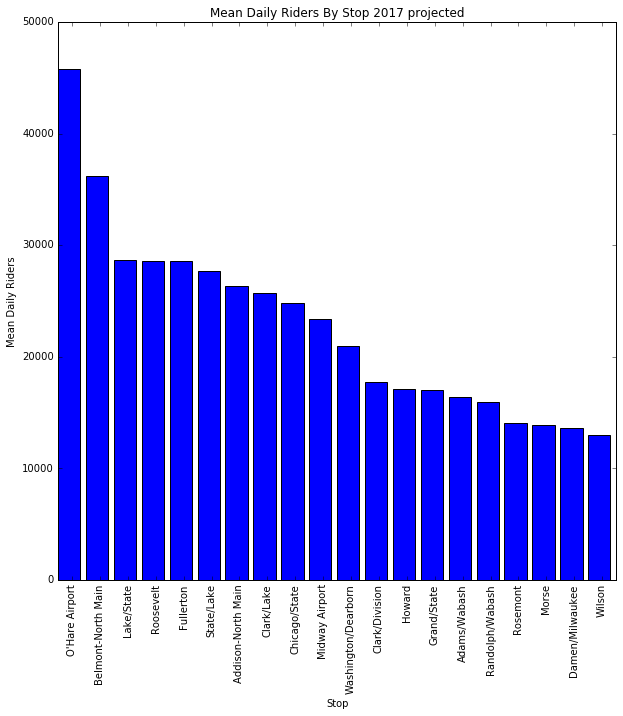

In [35]:
topten(databack[databack.year == 2017],20, extratext = '2017 projected')

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


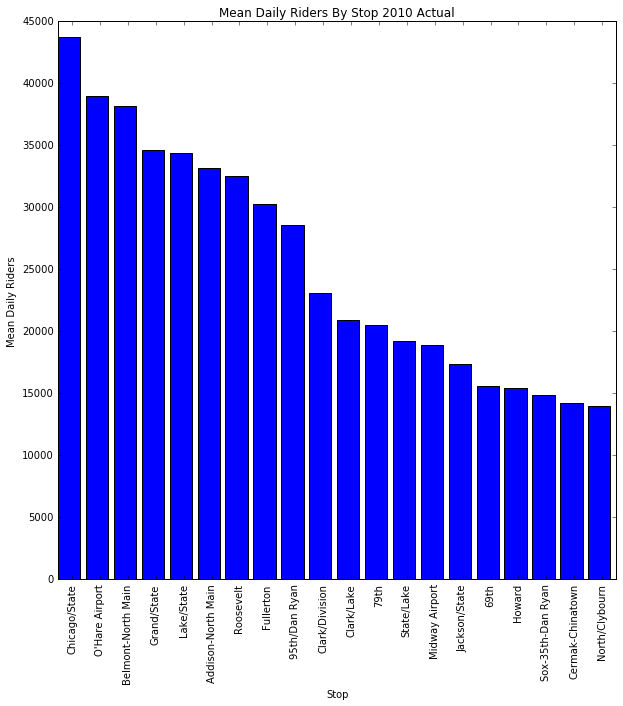

In [36]:
topten(sytotals[sytotals.stationname != 'Total'][sytotals.year == 2010],20, extratext = '2010 Actual')

In [37]:
dfsort = pd.DataFrame(databack.groupby(['stationname','month'], as_index = False)['rides'].mean())
dfsort = dfsort.sort_values(['rides'], ascending = False)[:20]
dfsort

,stationname,month,rides
1184,O'Hare Airport,9.0,63866.405333
1180,O'Hare Airport,5.0,58856.511807
1183,O'Hare Airport,8.0,58005.325467
1186,O'Hare Airport,11.0,57986.507830
1182,O'Hare Airport,7.0,53175.839704
223,Belmont-North Main,8.0,48644.838112
221,Belmont-North Main,6.0,48300.095066
222,Belmont-North Main,7.0,46195.099709
1185,O'Hare Airport,10.0,45841.400603
370,Chicago/State,11.0,45113.603612


In [38]:
months = np.arange(1,13)
for month in months:
    dfsort = pd.DataFrame(databack[databack.month == month].groupby(['stationname'], as_index = False)['rides'].mean())
    dfsort = dfsort.sort_values('rides', ascending = False)[:1]

In [39]:
np.arange(1,13,.5).shape

(24,)

In [40]:
def monthmaxes(dataframe, extratext = ''):
    monthnames = ['January:','February:','March:','April:','May:','June:','July:','August:',
                  'September:','October:','November:','December:']
    vals = []
    names = []
    for month in np.arange(1,13):
        dfsort = pd.DataFrame(dataframe[dataframe.month == month].groupby(['stationname'], as_index = False)['rides'].mean())
        dfsort = dfsort.sort_values('rides', ascending = False)[:1]
        vals.append(dfsort.rides.values[0])
        names.append(monthnames[month-1])
        names.append(dfsort.stationname.values[0])
    
        
        
    fig, ax = plt.subplots(figsize = [10,10])#


    error_config = {'ecolor': '0.3'}

    rects1 = plt.bar(months, vals)

    plt.xlabel('Month/Stop')
    plt.ylabel('Mean Daily Riders')
    plt.title('Mean Daily Riders In Highest Traffic Stop Each Month ' + extratext)
    plt.xlim(1,13,)
    plt.xticks(np.arange(1,13,.5) +.15 ,names, rotation = 90)


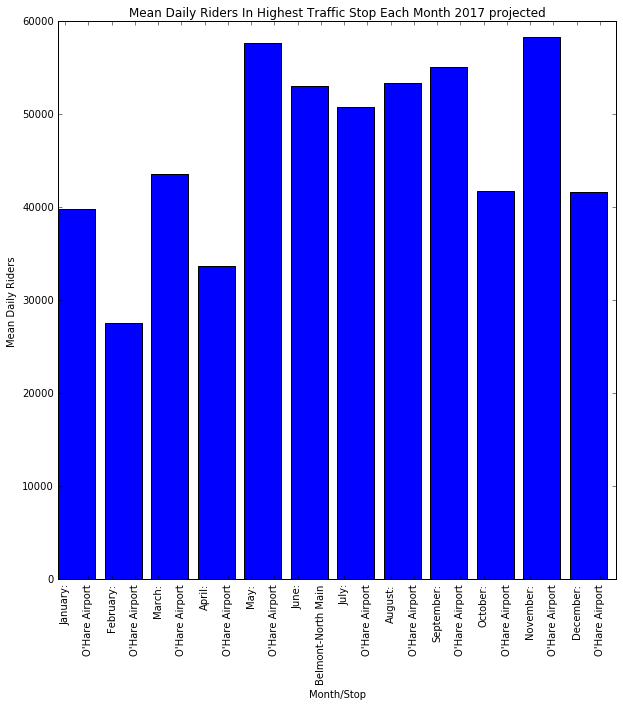

In [41]:
monthmaxes(databack[databack.year == 2017], extratext = '2017 projected')

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


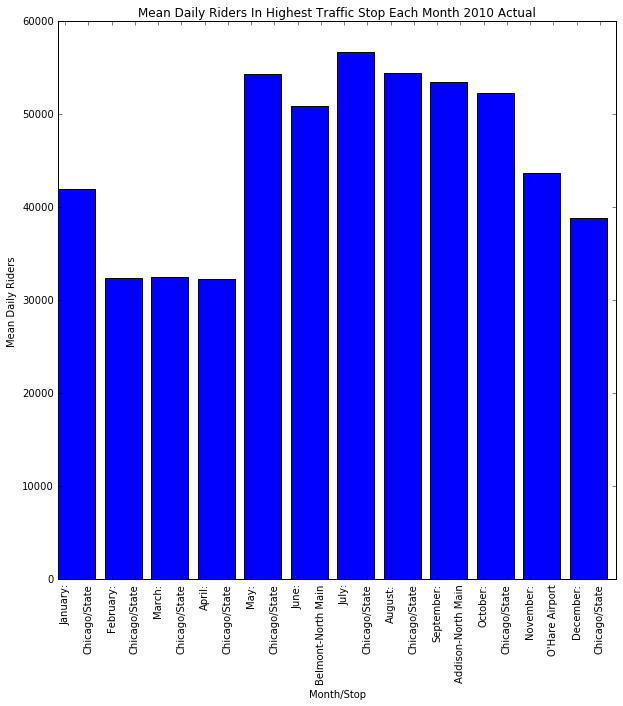

In [42]:
monthmaxes(sytotals[sytotals.stationname != 'Total'][sytotals.year == 2010], extratext = '2010 Actual')